# Open dataset from CSV

In [22]:
import pandas as pd

csv_path = 'Used german cars.csv'
df = pd.read_csv(csv_path, sep=';', quotechar='"')
df.head(3)

,Make,Model,Build Year,Engine Size,Transmission,Mileage [km],Fuel,Fuel efficiency,Price [EUR]
0,Audi,A1,2017,1.4,Manual,25318,Petrol,55.4,12500
1,Audi,A6,2016,2.0,Automatic,58251,Diesel,64.2,16500
2,Audi,A1,2016,1.4,Manual,48183,Petrol,55.4,11000


In [23]:
df.describe()

,Build Year,Engine Size,Mileage [km],Fuel efficiency,Price [EUR]
count,34568.000000,34568.000000,34568.000000,34568.000000,34568.000000
mean,2017.168132,2.058086,38525.910553,54.190063,23529.611490
std,2.249212,0.583447,37401.207586,21.245980,11706.977313
min,1970.000000,0.000000,2.000000,1.100000,650.000000
25%,2016.000000,1.600000,9441.750000,44.100000,15990.000000
50%,2017.000000,2.000000,27622.500000,52.300000,21000.000000
75%,2019.000000,2.100000,56315.000000,62.800000,28298.000000
max,2020.000000,6.600000,519707.000000,470.800000,159999.000000


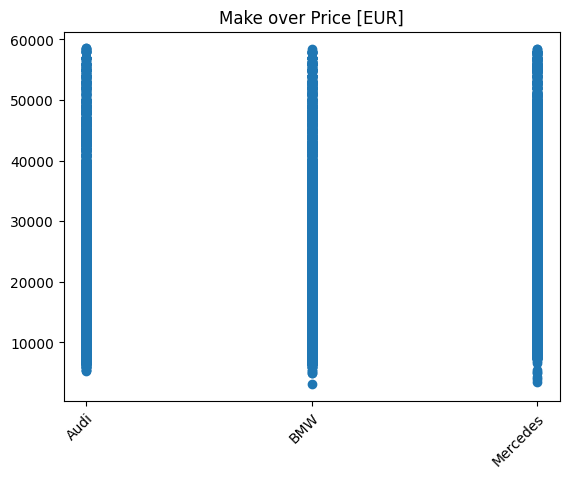

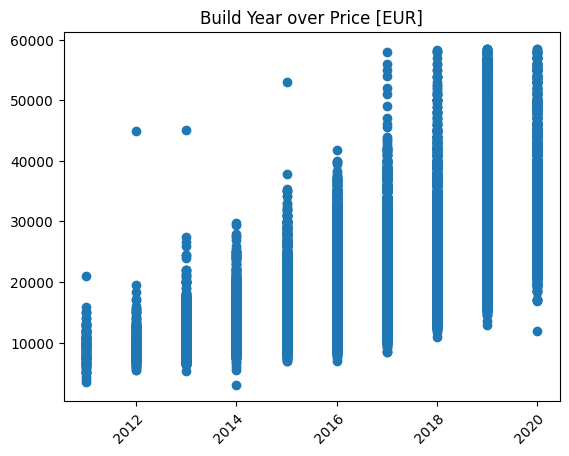

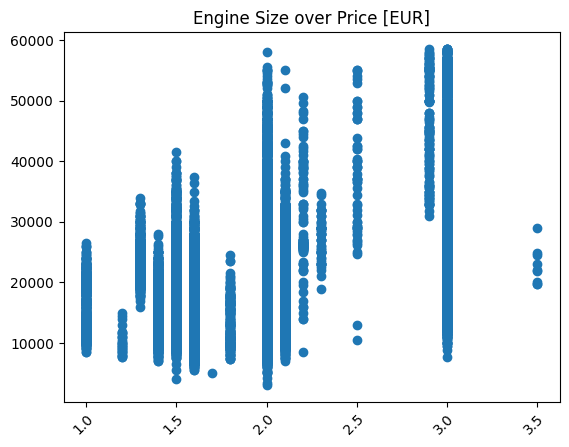

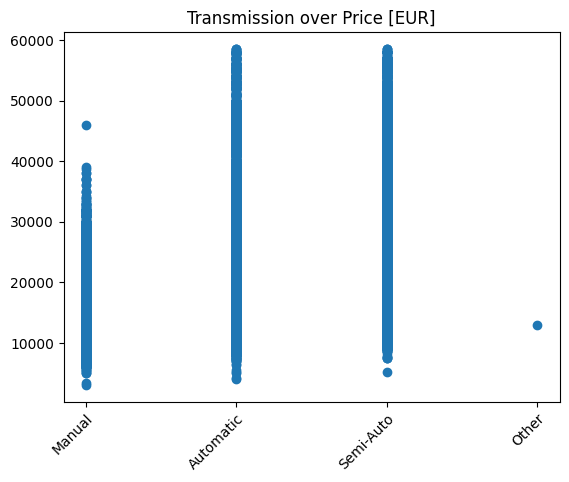

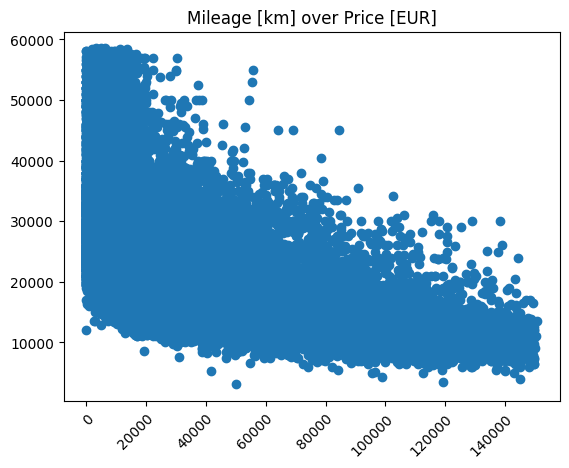

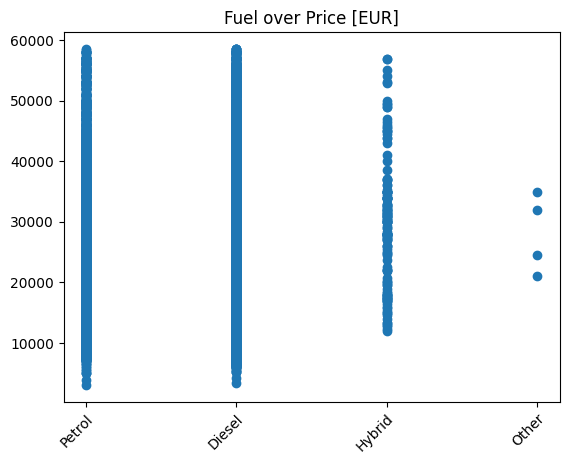

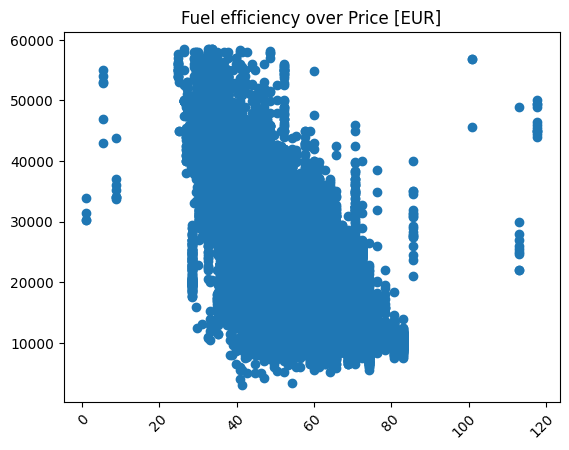

In [29]:
import matplotlib.pyplot as plt

for col in df.columns:
    if not col == 'Price [EUR]':
        plt.scatter(x=df[col], y=df['Price [EUR]'])
        plt.title(label=f'{col} over Price [EUR]')
        plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
        plt.show()

We drop the 'Model' column, as there is no point in training the model on certain cars and it does not add any improvement to our model

In [24]:
df.drop('Model', inplace=True, axis=1) # The 'Model' column is not useful for our model

## Remove Outliers using Z-score

In [26]:
import numpy as np
from scipy import stats

z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 3).all(axis=1)]

<Axes: xlabel='Price [EUR]', ylabel='Count'>

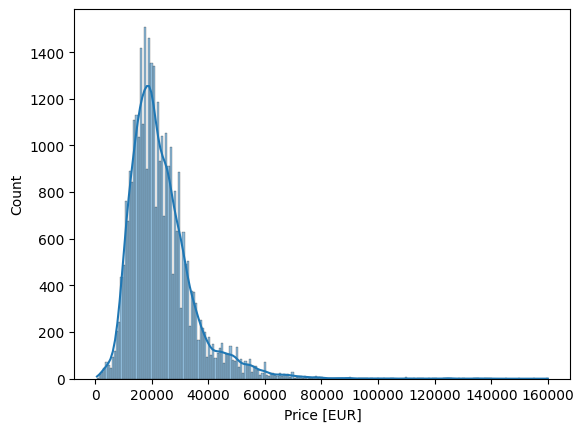

In [25]:
import seaborn as sns

sns.histplot(data=df, x='Price [EUR]', kde=True)

To get a better reading of the variance in our data we plt it as a histogram. The histogram of the prices displays a right-skewed (positively skewed) distribution. Log transformation is commonly applied to right-skewed data to compress the long tail and expand the left-hand side of the distribution, making it more symmetric and potentially more like a normal distribution, potentiall stabilizing variance across levels of an independent variable.

In [27]:
X = df.drop('Price [EUR]', axis=1)
y = np.log(df['Price [EUR]']) # Log transform the target variable

<Axes: ylabel='Count'>

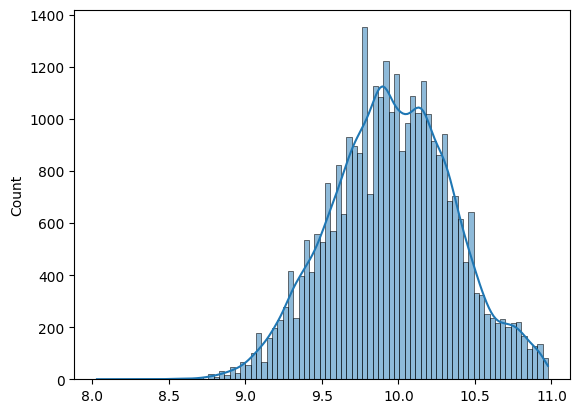

In [28]:
sns.histplot(data=df, x=y.values, kde=True)

The distribution has become more symmetric compared to the original right-skewed distribution. The long tail to the right has been compressed, and the data is more bell-shaped now, although it is not perfectly normal. There's still some irregularity, with a few peaks.

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## One-hot encode categorical values

We have three categorical parameters that need to be converted into numerical form:
- Make
- Fuel
- Transmission

Applying one hot encoding on these three parameters allows us to feed them into our model

In [31]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ["Make", "Fuel", "Transmission"]
encoder = OneHotEncoder(drop='first', sparse=False)
preprocessor = ColumnTransformer(
    transformers=[('cat', encoder, categorical_features)], 
    remainder='passthrough'
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

/Users/adisveletanlic/git/regression-seminar/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Create regression models

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor

lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
ab = AdaBoostRegressor(estimator=RandomForestRegressor(random_state=42), random_state=42)

models = {
    'Linear Regression': lr,
    'Random Forest': rf,
    'AdaBoost': ab
}

## Train and measure model performances

In [34]:
from sklearn.metrics import mean_absolute_percentage_error

for model_name, model in models.items():
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)
    print(f'[{model_name}] MAPE: {mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))}')

[Linear Regression] MAPE: 0.11499730667650776
[Random Forest] MAPE: 0.07938363013487225
[AdaBoost] MAPE: 0.08173688417559406


## Create stacking regressor to utilize ensemble functionality and achieve higher MAPE score

In [35]:
from sklearn.ensemble import StackingRegressor

estimators = [("lr", lr),("rf", rf),("ab", ab)]
st = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

st.fit(X_train_encoded, y_train)

y_pred = st.predict(X_test_encoded)

print(f"[Stacking Regressor] MAPE: {mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))}")

[Stacking Regressor] MAPE: 0.07937517652454229
